In [32]:
# Import required libraries

import numpy as np
import pandas as pd

import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa import tsatools
from dmba import regressionSummary
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import warnings
pd.options.display.max_columns = 20 
pd.options.display.max_rows = 20
pd.options.display.max_colwidth = 80
np.set_printoptions(precision=4, suppress=True) # Displays only upto 4 decimals
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning) # Suppress specific FutureWarnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [2]:
# Load the Excel files
df_production = pd.read_excel("C://ISB//Term 5//Foundation Project//Final submission//Final dataset//monthly sugar production.xlsx")
df_prices = pd.read_excel("C://ISB//Term 5//Foundation Project//Final submission//Final dataset//Historical sugar prices_indexmundi.xlsx")
df_cpi = pd.read_excel("C://ISB//Term 5//Foundation Project//Final submission//Final dataset//RBI-CPI-MonthlyStats.xlsx", skiprows=1)

In [3]:
df_production

,Month,Year,month Production of sugar \nlakh tonnes,Sugar export by India\nmetric tonnes,Sugar Imports In India\nmeric tonnes
0,October,2023,4.36,462256.0,76719.0
1,November,2023,43.82,669226.0,133.0
2,December,2023,73.02,1586842.0,77946.0
3,January,2023,73.79,1394166.0,73412.0
4,February,2023,63.49,1166624.0,48.0
...,...,...,...,...,...
163,May,2010,4.23,NaN,NaN
164,June,2010,0.69,NaN,NaN
165,July,2010,0.55,NaN,NaN
166,August,2010,1.13,NaN,NaN


In [4]:
df_prices

,Date,Price,Change
0,2018-01-01,39.200000,-
1,2018-02-01,39.100000,-0.002551
2,2018-03-01,38.944444,-0.003978
3,2018-04-01,37.703704,-0.031859
4,2018-05-01,35.358423,-0.062203
...,...,...,...
78,2024-07-01,42.695473,-0.009028
79,2024-08-01,43.266667,0.013378
80,2024-09-01,42.675926,-0.013653
81,2024-10-01,42.884444,0.004886


In [5]:
df_cpi

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Index,Inflation (%),Index.1,Inflation (%).1,Index.2,Inflation (%).2
0,OCT-2024,A) General Index,Provisional,199.5,6.68,193.7,5.62,196.8,6.21
1,OCT-2024,A.1) Food and beverages,Provisional,206.7,9.66,214.0,9.80,209.4,9.69
2,OCT-2024,A.1.1) Cereals and products,Provisional,196.3,7.27,194.0,6.19,195.6,6.94
3,OCT-2024,A.1.2) Meat and fish,Provisional,221.6,3.02,230.5,3.41,224.7,3.17
4,OCT-2024,A.1.3) Egg,Provisional,194,4.75,198.8,5.02,195.9,4.87
...,...,...,...,...,...,...,...,...,...
3970,JAN-2013,A.6.2) Health,Final,104,NaN,104.1,NaN,104.0,NaN
3971,JAN-2013,A.6.3) Transport and communication,Final,103.3,NaN,103.2,NaN,103.2,NaN
3972,JAN-2013,A.6.4) Recreation and amusement,Final,103.4,NaN,102.9,NaN,103.1,NaN
3973,JAN-2013,A.6.5) Education,Final,103.8,NaN,103.5,NaN,103.6,NaN


In [6]:
# Rename columns for clarity and consistency
df_production.columns = [
    'Month', 
    'Year', 
    'Monthly Production (lakh tonnes)', 
    'Sugar Export (metric tonnes)', 
    'Sugar Import (metric tonnes)'
]
df_prices.columns = ['Date', 'Sugar Price', 'Price Change']

df_cpi.columns = ['Month', 'Commodity', 'Provisional/Final', 'Rural Index', 'Rural Inflation %', 'Urban Index', 'Urban Inflation %', 'Combined Index', 'Combined Inflation %']

In [7]:
# Combine 'Month' and 'Year' into a single 'Date' column in production_data
df_production['Date'] = pd.to_datetime(df_production['Month'] + ' ' + df_production['Year'].astype(str))

C:\Users\pavan\AppData\Local\Temp\ipykernel_49260\2002471536.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_production['Date'] = pd.to_datetime(df_production['Month'] + ' ' + df_production['Year'].astype(str))


In [8]:
# Drop the original 'Month' and 'Year' columns as they are now combined
df_production.drop(columns=['Month', 'Year'], inplace=True)

In [9]:
df_production.head(5)

,Monthly Production (lakh tonnes),Sugar Export (metric tonnes),Sugar Import (metric tonnes),Date
0,4.36,462256.0,76719.0,2023-10-01
1,43.82,669226.0,133.0,2023-11-01
2,73.02,1586842.0,77946.0,2023-12-01
3,73.79,1394166.0,73412.0,2023-01-01
4,63.49,1166624.0,48.0,2023-02-01


In [10]:
# Ensure the 'Date' column in prices_data is a datetime object
df_prices['Date'] = pd.to_datetime(df_prices['Date'])

In [11]:
df_prices.head(5)

,Date,Sugar Price,Price Change
0,2018-01-01,39.200000,-
1,2018-02-01,39.100000,-0.002551
2,2018-03-01,38.944444,-0.003978
3,2018-04-01,37.703704,-0.031859
4,2018-05-01,35.358423,-0.062203


In [12]:
# Merge the two datasets on the 'Date' column
data = pd.merge(df_production, df_prices, on='Date', how='outer')

# Sort the merged data by date
data.sort_values('Date', inplace=True)

# Reset the index for a clean dataset
data.reset_index(drop=True, inplace=True)

# Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

In [13]:
data.head(5)

,Monthly Production (lakh tonnes),Sugar Export (metric tonnes),Sugar Import (metric tonnes),Date,Sugar Price,Price Change
0,40.94,NaN,NaN,2010-01-01,NaN,NaN
1,37.51,NaN,NaN,2010-02-01,NaN,NaN
2,29.49,NaN,NaN,2010-03-01,NaN,NaN
3,14.19,NaN,NaN,2010-04-01,NaN,NaN
4,4.23,NaN,NaN,2010-05-01,NaN,NaN


In [14]:
# Drop the extra columns, as present in the raw dataset
df_cpi.drop(columns=['Rural Index', 'Rural Inflation %', 'Urban Index', 'Urban Inflation %', 'Combined Index'], inplace=True)
df_cpi

,Month,Commodity,Provisional/Final,Combined Inflation %
0,OCT-2024,A) General Index,Provisional,6.21
1,OCT-2024,A.1) Food and beverages,Provisional,9.69
2,OCT-2024,A.1.1) Cereals and products,Provisional,6.94
3,OCT-2024,A.1.2) Meat and fish,Provisional,3.17
4,OCT-2024,A.1.3) Egg,Provisional,4.87
...,...,...,...,...
3970,JAN-2013,A.6.2) Health,Final,NaN
3971,JAN-2013,A.6.3) Transport and communication,Final,NaN
3972,JAN-2013,A.6.4) Recreation and amusement,Final,NaN
3973,JAN-2013,A.6.5) Education,Final,NaN


In [15]:
# Filtering the data to only look at the Final(non-provisional) Sugar Commodity CPI numbers
df_cpi['Commodity'] = df_cpi['Commodity'].apply(str.lower)
df_cpi = df_cpi[df_cpi["Commodity"].str.contains("sugar")]
df_cpi
df_cpi = df_cpi[df_cpi["Provisional/Final"].str.lower() == 'final']
df_cpi

,Month,Commodity,Provisional/Final,Combined Inflation %
38,SEP-2024,a.1.9) sugar and confectionery,Final,3.46
66,AUG-2024,a.1.9) sugar and confectionery,Final,4.70
94,JUL-2024,a.1.9) sugar and confectionery,Final,5.22
122,JUN-2024,a.1.9) sugar and confectionery,Final,5.83
150,MAY-2024,a.1.9) sugar and confectionery,Final,5.70
...,...,...,...,...
3846,MAY-2013,a.1.9) sugar and confectionery,Final,NaN
3874,APR-2013,a.1.9) sugar and confectionery,Final,NaN
3902,MAR-2013,a.1.9) sugar and confectionery,Final,NaN
3930,FEB-2013,a.1.9) sugar and confectionery,Final,NaN


In [16]:
# Dropping the Commodity and Provisional/Final columns as they are not needed anymore
df_cpi = df_cpi.drop(columns=['Commodity', 'Provisional/Final']).dropna().reset_index(drop=True)
df_cpi

,Month,Combined Inflation %
0,SEP-2024,3.46
1,AUG-2024,4.70
2,JUL-2024,5.22
3,JUN-2024,5.83
4,MAY-2024,5.70
...,...,...
124,MAY-2014,-0.29
125,APR-2014,-1.64
126,MAR-2014,-4.41
127,FEB-2014,-5.61


In [17]:
# Converting the existing month column into the correct (python-friendly) datetime format and renaming the columns
df_cpi['Month'] = pd.to_datetime(df_cpi['Month'], format=r"%b-%Y")
df_cpi.columns = ['Date', 'CPI']
df_cpi

,Date,CPI
0,2024-09-01,3.46
1,2024-08-01,4.70
2,2024-07-01,5.22
3,2024-06-01,5.83
4,2024-05-01,5.70
...,...,...
124,2014-05-01,-0.29
125,2014-04-01,-1.64
126,2014-03-01,-4.41
127,2014-02-01,-5.61


In [18]:
# Merge the cpi data with the merged dataset of production and prices on the 'Date' column
data = pd.merge(data, df_cpi, on='Date', how='outer')

# Sort the merged data by date
data.sort_values('Date', inplace=True)

# Reset the index for a clean dataset
data.reset_index(drop=True, inplace=True)

# Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

data.head(5)

,Monthly Production (lakh tonnes),Sugar Export (metric tonnes),Sugar Import (metric tonnes),Date,Sugar Price,Price Change,CPI
0,40.94,NaN,NaN,2010-01-01,NaN,NaN,NaN
1,37.51,NaN,NaN,2010-02-01,NaN,NaN,NaN
2,29.49,NaN,NaN,2010-03-01,NaN,NaN,NaN
3,14.19,NaN,NaN,2010-04-01,NaN,NaN,NaN
4,4.23,NaN,NaN,2010-05-01,NaN,NaN,NaN


In [19]:
#  Check for Missing Values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
Monthly Production (lakh tonnes)    11
Sugar Export (metric tonnes)        59
Sugar Import (metric tonnes)        59
Date                                 0
Sugar Price                         96
Price Change                        96
CPI                                 50
dtype: int64


In [20]:
# Filter rows where all five columns have non-missing values
complete_data = data.dropna(subset=[
    # 'Monthly Production (lakh tonnes)', 
    # 'Sugar Export (metric tonnes)', 
    # 'Sugar Import (metric tonnes)', 
    'Sugar Price',
    # 'CPI'
])

# Display the dates where all five columns have data
dates_with_all_data = complete_data['Date']

print("Dates with all five attributes available:")
print(dates_with_all_data)

Dates with all five attributes available:
96    2018-01-01
97    2018-02-01
98    2018-03-01
99    2018-04-01
100   2018-05-01
         ...    
174   2024-07-01
175   2024-08-01
176   2024-09-01
177   2024-10-01
178   2024-11-01
Name: Date, Length: 83, dtype: datetime64[ns]


In [21]:
complete_data = complete_data.round(2).reset_index(drop=True)

In [22]:
complete_data

,Monthly Production (lakh tonnes),Sugar Export (metric tonnes),Sugar Import (metric tonnes),Date,Sugar Price,Price Change,CPI
0,67.67,97131.0,321130.0,2018-01-01,39.20,-,2.77
1,60.54,114127.0,0.0,2018-02-01,39.10,-0.002551,-0.17
2,51.64,134766.0,59110.0,2018-03-01,38.94,-0.003978,-1.61
3,28.48,159955.0,0.0,2018-04-01,37.70,-0.031859,-4.05
4,9.18,218721.0,135470.0,2018-05-01,35.36,-0.062203,-8.21
...,...,...,...,...,...,...,...
78,NaN,NaN,NaN,2024-07-01,42.70,-0.009028,5.22
79,NaN,NaN,NaN,2024-08-01,43.27,0.013378,4.70
80,NaN,NaN,NaN,2024-09-01,42.68,-0.013653,3.46
81,NaN,NaN,NaN,2024-10-01,42.88,0.004886,NaN


In [24]:
complete_data.to_csv('final_sugar_price_forecasting_data.csv', index=False)

In [25]:
# Select features, target variable, and dates
X = complete_data[['Monthly Production (lakh tonnes)', 'Sugar Export (metric tonnes)', 'Sugar Import (metric tonnes)', 'CPI']]
y = complete_data['Sugar Price']
dates = complete_data['Date']


# Split into training (before 2022) and testing (2022-2023) data
train_size = int(len(complete_data) * 0.8)
train_data = complete_data[:train_size]
test_data = complete_data[train_size:]

In [26]:
train_data

,Monthly Production (lakh tonnes),Sugar Export (metric tonnes),Sugar Import (metric tonnes),Date,Sugar Price,Price Change,CPI
0,67.67,97131.0,321130.0,2018-01-01,39.20,-,2.77
1,60.54,114127.0,0.0,2018-02-01,39.10,-0.002551,-0.17
2,51.64,134766.0,59110.0,2018-03-01,38.94,-0.003978,-1.61
3,28.48,159955.0,0.0,2018-04-01,37.70,-0.031859,-4.05
4,9.18,218721.0,135470.0,2018-05-01,35.36,-0.062203,-8.21
...,...,...,...,...,...,...,...
61,63.49,1166624.0,48.0,2023-02-01,41.10,0.007363,1.26
62,42.29,921788.0,76658.0,2023-03-01,41.18,0.001788,1.01
63,18.35,610594.0,180.0,2023-04-01,41.38,0.004892,1.93
64,4.38,420884.0,208426.0,2023-05-01,41.35,-0.000657,2.51


In [27]:
test_data

,Monthly Production (lakh tonnes),Sugar Export (metric tonnes),Sugar Import (metric tonnes),Date,Sugar Price,Price Change,CPI
66,0.87,243922.0,290332.0,2023-07-01,42.17,0.009467,3.75
67,1.53,300613.0,152146.0,2023-08-01,42.75,0.01365,3.80
68,1.55,322979.0,252484.0,2023-09-01,43.65,0.021019,4.61
69,4.36,462256.0,76719.0,2023-10-01,43.85,0.004673,5.50
70,43.82,669226.0,133.0,2023-11-01,44.46,0.013846,6.55
71,73.02,1586842.0,77946.0,2023-12-01,44.33,-0.002959,7.22
72,NaN,NaN,NaN,2024-01-01,44.18,-0.003314,7.43
73,NaN,NaN,NaN,2024-02-01,42.10,-0.047119,7.48
74,NaN,NaN,NaN,2024-03-01,42.21,0.002753,7.25
75,NaN,NaN,NaN,2024-04-01,43.08,0.020522,6.02


## REGRESSION ANALYSIS

In [28]:
X_train = train_data[['Monthly Production (lakh tonnes)', 'Sugar Export (metric tonnes)', 'Sugar Import (metric tonnes)', 'CPI']]
y_train = train_data['Sugar Price']
X_test = test_data[['Monthly Production (lakh tonnes)', 'Sugar Export (metric tonnes)', 'Sugar Import (metric tonnes)', 'CPI']]
y_test = test_data['Sugar Price']
dates_test = test_data['Date']

In [29]:
# Add constant for OLS regression
X_train_ols = sm.add_constant(X_train)
X_test_ols = sm.add_constant(X_test)

# Fit OLS regression model
ols_model = sm.OLS(y_train, X_train_ols).fit()

# Display OLS regression summary
print("OLS Regression Summary:")
print(ols_model.summary())

OLS Regression Summary:
                            OLS Regression Results                            
Dep. Variable:            Sugar Price   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     15.73
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           6.77e-09
Time:                        22:27:31   Log-Likelihood:                -82.530
No. Observations:                  66   AIC:                             175.1
Df Residuals:                      61   BIC:                             186.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [30]:
# Predictions on test data
y_pred = ols_model.predict(X_test_ols)

In [33]:
# Calculate error metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mad = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mpe = np.mean((y_test - y_pred) / y_test) * 100
r2 = r2_score(y_test, y_pred)

# Key metrics
metrics = {
    "RMSE": rmse,
    "MSE": mse,
    "MAD": mad,
    "MAPE": mape,
    "MPE": mpe,
    "R2": r2
}

print("\nOverall Key Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

ValueError: Input contains NaN.

In [34]:
# Metrics for the last six months (July 2023 - Dec 2023)
short_term_data = test_data[test_data['Date'] >= '2023-07-01']
X_short_term = sm.add_constant(short_term_data[['Monthly Production (lakh tonnes)', 'Sugar Export (metric tonnes)', 'Sugar Import (metric tonnes)', 'CPI']])
y_short_term = short_term_data['Sugar Price']
dates_short_term = short_term_data['Date']

y_pred_short_term = ols_model.predict(X_short_term)

rmse_short = np.sqrt(mean_squared_error(y_short_term, y_pred_short_term))
mse_short = mean_squared_error(y_short_term, y_pred_short_term)
mad_short = mean_absolute_error(y_short_term, y_pred_short_term)
mape_short = np.mean(np.abs((y_short_term - y_pred_short_term) / y_short_term)) * 100
mpe_short = np.mean((y_short_term - y_pred_short_term) / y_short_term) * 100
r2_short = r2_score(y_short_term, y_pred_short_term)

short_term_metrics = {
    "RMSE": rmse_short,
    "MSE": mse_short,
    "MAD": mad_short,
    "MAPE": mape_short,
    "MPE": mpe_short,
    "R2": r2_short
}

print("\nShort-Term Key Metrics (July 2023 - Dec 2023):")
for metric, value in short_term_metrics.items():
    print(f"{metric}: {value:.4f}")

ValueError: Input contains NaN.

In [35]:
# Compare overall vs short-term metrics
comparison = pd.DataFrame({
    "Overall Metrics": metrics,
    "Short-Term Metrics": short_term_metrics
})
print("\nComparison of Overall vs Short-Term Metrics:")
print(comparison)

NameError: name 'metrics' is not defined

In [36]:
# Create DataFrame for actual vs predicted
comparison_df = pd.DataFrame({
    "Date": dates_test,
    "Actual": y_test,
    "Predicted": y_pred,
    "Error": y_test - y_pred
}).reset_index(drop=True)

# Save to Excel
comparison_df.to_excel("actual_vs_predicted_with_date_regression.xlsx", index=False)

In [37]:
comparison_df

,Date,Actual,Predicted,Error
0,2023-07-01,42.17,40.850573,1.319427
1,2023-08-01,42.75,40.617896,2.132104
2,2023-09-01,43.65,40.964677,2.685323
3,2023-10-01,43.85,40.837037,3.012963
4,2023-11-01,44.46,40.764324,3.695676
5,2023-12-01,44.33,41.399794,2.930206
6,2024-01-01,44.18,NaN,NaN
7,2024-02-01,42.10,NaN,NaN
8,2024-03-01,42.21,NaN,NaN
9,2024-04-01,43.08,NaN,NaN


In [38]:
# Plot actual vs predicted with confidence intervals
conf_int = ols_model.conf_int(alpha=0.05)
plt.figure(figsize=(10, 6))
plt.plot(dates_test, y_test, label='Actual', color='blue')
plt.plot(dates_test, y_pred, label='Predicted', color='red')
plt.fill_between(dates_test, y_pred + 1.96 * np.sqrt(mse), y_pred - 1.96 * np.sqrt(mse), color='pink', alpha=0.3, label='Confidence Interval (95%)')
plt.xlabel('Date')
plt.ylabel('Sugar Price')
plt.title('Sugar Price Prediction with Confidence Intervals')
plt.legend()
plt.grid()
plt.show()

NameError: name 'mse' is not defined

## LSTM WITH ALL VARIABLES

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

In [54]:
# Preprocessing
complete_data['Date'] = pd.to_datetime(complete_data['Date'])
df = complete_data.sort_values('Date')
selected_columns = ['Monthly Production (lakh tonnes)', 'Sugar Export (metric tonnes)', 
                    'Sugar Import (metric tonnes)', 'Sugar Price', 'CPI']
df_filtered = complete_data[['Date'] + selected_columns].dropna()

In [57]:
df_cleaned1 = df_filtered[(df_filtered['Date'] >= '01/01/2018') & (data['Date'] <= '01/12/2023')]

C:\Users\pavan\AppData\Local\Temp\ipykernel_49260\3775940797.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cleaned1 = df_filtered[(df_filtered['Date'] >= '01/01/2018') & (data['Date'] <= '01/12/2023')]


In [58]:
# Drop rows with missing values
df_cleaned1 = df_cleaned1.dropna()

In [59]:
df_cleaned1['Date'] = pd.to_datetime(df_cleaned1['Date'])
df = df_cleaned1.sort_values('Date')
selected_columns = ['Monthly Production (lakh tonnes)', 'Sugar Export (metric tonnes)', 
                    'Sugar Import (metric tonnes)', 'Sugar Price', 'CPI']
df_cleaned = df_cleaned1[['Date'] + selected_columns].dropna()

In [60]:
# Normalize features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_data = scaler_X.fit_transform(df_cleaned[selected_columns[:-1]].values)  # All except 'Sugar Price'
y_data = scaler_y.fit_transform(df_cleaned[['Sugar Price']].values)        # 'Sugar Price'

In [61]:
# Combine normalized data for sequence creation
data_scaled = np.hstack((X_data, y_data))
dates = df_cleaned['Date'].values


In [62]:
# Create sequences
def create_sequences(data, target_col_index, n_steps):
    X, y, sequence_dates = [], [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i, :-1])  # Last `n_steps` rows (exclude target column)
        y.append(data[i, target_col_index])  # Target value at `i`
        sequence_dates.append(dates[i])  # Corresponding date
    return np.array(X), np.array(y), np.array(sequence_dates)

In [63]:
# Define parameters
n_steps = 4
target_col_index = data_scaled.shape[1] - 1  # Index of the target column (last column)

# Create input features (X), target (y), and sequence dates
X, y, sequence_dates = create_sequences(data_scaled, target_col_index, n_steps)

# Train-test split based on date
train_mask = sequence_dates < np.datetime64('2023-02-01')
test_mask = sequence_dates >= np.datetime64('2023-02-01')

X_train_1, X_test_1 = X[train_mask], X[test_mask]
y_train_1, y_test_1 = y[train_mask], y[test_mask]
test_dates = sequence_dates[test_mask]

In [64]:
# Define model builder
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(LSTM(
            units=hp.Int('units_' + str(i), min_value=50, max_value=200, step=50),
            activation='relu',
            return_sequences=True if i < hp.Int('num_layers', 1, 3) - 1 else False,
            input_shape=(n_steps, X_train_1.shape[2]) if i == 0 else None
        ))
        model.add(Dropout(hp.Float('dropout_' + str(i), 0.2, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss='mean_squared_error'
    )
    return model

In [66]:
# Hyperparameter tuning
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='sugar_price_tuning'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train_1, y_train_1, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal hyperparameters:
- LSTM layers: {best_hps.get('num_layers')}
- Units in first layer: {best_hps.get('units_0')}
- Learning rate: {best_hps.get('learning_rate')}
""")

# Build and train final model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_1, y_train_1, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate model
loss = best_model.evaluate(X_test_1, y_test_1)
print(f"Test Loss: {loss}")

# Make predictions
predictions_scaled = best_model.predict(X_test_1)

# Inverse transform predictions and actual values
y_test_actual = scaler_y.inverse_transform(y_test_1.reshape(-1, 1))
predictions_actual = scaler_y.inverse_transform(predictions_scaled)

# Save results
results = pd.DataFrame({
    'Date': test_dates,
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions_actual.flatten()
})
results.to_excel('actual_vs_predicted_sugar_price_lstm.xlsx', index=False)

Trial 90 Complete [00h 00m 10s]
val_loss: 0.005486996378749609

Best val_loss So Far: 0.0010621199617162347
Total elapsed time: 00h 12m 50s

Optimal hyperparameters:
- LSTM layers: 3
- Units in first layer: 100
- Learning rate: 0.001

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 536ms/step - loss: 0.2481 - val_loss: 0.3352
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2255 - val_loss: 0.3028
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1939 - val_loss: 0.2608
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1669 - val_loss: 0.2051
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1309 - val_loss: 0.1338
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0844 - val_loss: 0.0549
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0420 - val_loss: 0.0095
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0264 - val_loss: 0.0358
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0560 - val_loss: 0.0196
Epoch 10

In [67]:
# Error Metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
mape = mean_absolute_percentage_error(y_test_actual, predictions_actual)
mse = mean_squared_error(y_test_actual, predictions_actual)
mad = mean_absolute_error(y_test_actual, predictions_actual)
mpe = np.mean((y_test_actual - predictions_actual) / y_test_actual) * 100

print({
    'RMSE': rmse,
    'MAPE': mape,
    'MSE': mse,
    'MAD': mad,
    'MPE': mpe
})

{'RMSE': 2.6024591977277556, 'MAPE': 0.052552493054800295, 'MSE': 6.772793875837793, 'MAD': 2.270219282670455, 'MPE': 5.25524930548003}


In [68]:
# Assuming y_test_actual and predictions_actual are the actual and predicted values
# Inverse transformed if necessary before calculating R²
r2 = r2_score(y_test_actual, predictions_actual)

print(f"R² (Coefficient of Determination): {r2}")

R² (Coefficient of Determination): -3.3109177928758564


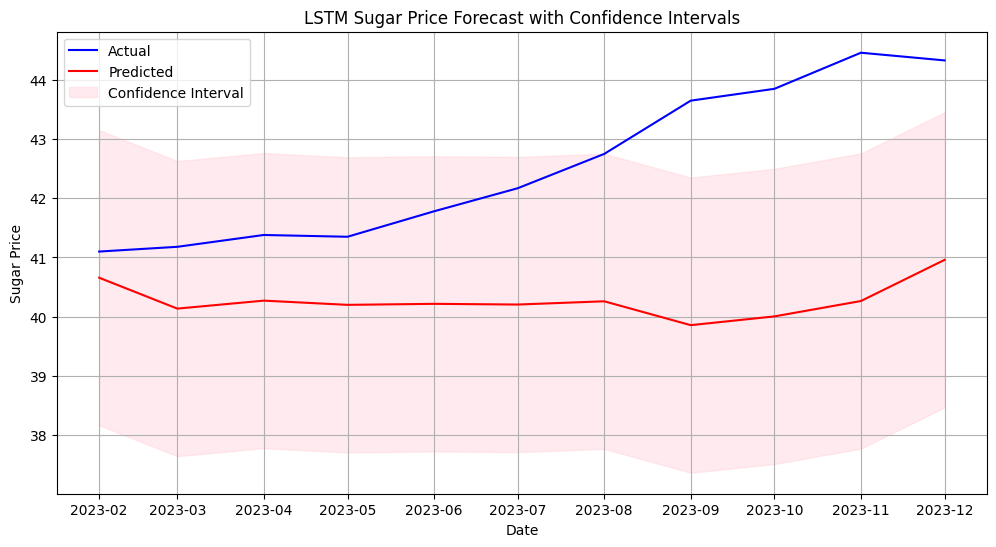

In [69]:
# Assuming you have y_test_actual and predictions_actual from your LSTM model
# Residuals (errors)
residuals = y_test_actual.flatten() - predictions_actual.flatten()

# Calculate the standard deviation of the residuals
residual_std = np.std(residuals)

# Define confidence intervals (95% confidence interval)
upper_limit = predictions_actual.flatten() + 1.96 * residual_std
lower_limit = predictions_actual.flatten() - 1.96 * residual_std

# Create a DataFrame for visualization
results_with_ci = pd.DataFrame({
    'Date': test_dates,  # Assuming `test_dates` contains the dates for the test set
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions_actual.flatten(),
    'Upper Limit': upper_limit,
    'Lower Limit': lower_limit
})

# Plot the results
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(results_with_ci['Date'], results_with_ci['Actual'], label='Actual', color='blue')

# Plot predicted values
plt.plot(results_with_ci['Date'], results_with_ci['Predicted'], label='Predicted', color='red')

# Plot confidence intervals
plt.fill_between(results_with_ci['Date'],
                 results_with_ci['Lower Limit'],
                 results_with_ci['Upper Limit'],
                 color='pink', alpha=0.3, label='Confidence Interval')

# Add labels, legend, and title
plt.title('LSTM Sugar Price Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Sugar Price')
plt.legend(loc='upper left')
plt.grid(True)

# Show plot
plt.show()